In [683]:
import math
import random
import pandas
import seaborn
import numpy as numpy
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch_geometric
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.dense import Linear, HeteroLinear
from torch_geometric.nn import GCNConv, GraphConv, pool, GATConv
from torch_geometric.utils import to_networkx, add_remaining_self_loops
from torch_geometric.loader import DataLoader

from torch.utils.tensorboard import SummaryWriter

In [684]:
def generate_spins(n):
    # vector radius
    RAD = 1.
    Theta = numpy.random.uniform(0., numpy.pi, n)  # random numbers between 0 and pi
    Phi = numpy.random.uniform(0., 2.*numpy.pi, n) # random numbers between 0 and 2*pi

    X = RAD*numpy.cos(Phi)*numpy.sin(Theta)
    Y = RAD*numpy.sin(Phi)*numpy.sin(Theta)
    Z = RAD*numpy.cos(Theta)
    
    spins = numpy.dstack([X, Y, Z], )[0]
    return spins

In [685]:
""" Create dataste of Pytorch Geometric Data objects """

nnodes = 50
dataset = []

for _ in range(10_000):
    # undirected graph contains edges in both direcitons
    source_nodes, target_nodes = [], []
    edge_weights = []
    for i in range(1, nnodes+1):
        source_nodes += [(i-1) % nnodes, i % nnodes]
        target_nodes += [i % nnodes, (i-1) % nnodes]
        
    x = torch.tensor(generate_spins(nnodes), dtype=torch.float)
    edge_index = torch.tensor([source_nodes, target_nodes])

    # edge_weights = numpy.random.random(size=(len(edge_index[0]))) * 2 - 1
    edge_weights = numpy.ones((len(edge_index[0])))
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # calculate resulting energy of the lattice
    energy = 0
    for i in range(1, nnodes):
        energy += float(numpy.dot(x[i-1], x[i])) #* edge_weights[i])

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=float(energy))
    dataset.append(data)

# check if edges are encoded correctly
for data in dataset:
    assert data.edge_index.max() < data.num_nodes

print(dataset[0])
dataset[0].x.dtype, dataset[0].edge_index.dtype, dataset[0].edge_attr.dtype, dataset[0].y

Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-2.442401859909296)


(torch.float32, torch.int64, torch.float32, -2.442401859909296)

In [686]:
dataset

[Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-2.442401859909296),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-2.512745313346386),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-3.374171372503042),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=0.29612428322434425),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-6.624755170196295),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=7.574138509109616),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=8.977158818393946),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=1.8701325468719006),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-8.82054677978158),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=3.8066154923290014),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=7.329256061464548),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=-0.12559589743614197),
 Data(x=[50, 3], edge_index=[2, 100], edge_attr=[100], y=9.115499

In [687]:
""" 
Splitting and batching the dataset 

A data loader which merges data objects from a 
torch_geometric.data.Dataset to a mini-batch. 
Data objects can be either of type Data or HeteroData.
"""


split = (len(dataset) // 10) * 2
train_dataset = dataset[split:]
test_dataset = dataset[:split]


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=5)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

Number of training batches: 800
Number of testing batches: 400


/home/benb/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


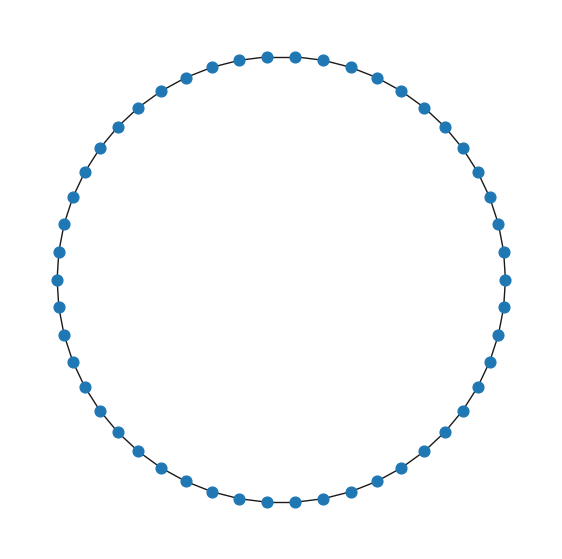

In [688]:
def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_circular(G, cmap="Set2", node_size=60,font_size=8)
    plt.show()
graph = dataset[0]
G = to_networkx(graph, to_undirected=True)
visualize_graph(G)


In [689]:
""" Architecture of the neural network """

class GraphNetRegression(torch.nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(GraphNetRegression, self).__init__()
        # self.conv1 = GATConv(num_node_features, 8, add_self_loops=True, heads=3)
        # self.conv2 = GATConv(24, 12, add_self_loops=True, dropout=0.5)

        self.conv1 = GCNConv(num_node_features, 27, improved=True)
        self.conv2 = GCNConv(27, 27, improved=True)
        
        self.fc = nn.Linear(27, 27)
        self.fc2 = nn.Linear(27, 27)
        self.fc3 = nn.Linear(27, num_output_features)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.2)

        x = pool.global_add_pool(x, batch)
        
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [690]:
num_node_features = 3
num_output_features = 1
model = GraphNetRegression(num_node_features, num_output_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train():
    model.train()
    # Iterate in batches over the training dataset.
    for data in train_loader:
        # Perform a single forward pass.
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        # print(out.shape, data.y.shape)
        loss = F.mse_loss(out.squeeze(), data.y) 
        
        # Derive gradients
        loss.backward()
        
        # Update parameters based on gradients.
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
     model.eval()
     mse_loss = 0
     with open('prediciton' ,'w') as f:
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)  
            loss = F.mse_loss(out.squeeze(), data.y.squeeze()) 
            pred_nums = [str(num) for num in out.squeeze().tolist()]
            true_nums = [str(num) for num in data.y.squeeze().tolist()]
            f.write(f"pred: {', '.join(pred_nums)}\n")
            f.write(f"true: {', '.join(true_nums)}\n")
            f.write("-------------\n")
            mse_loss += loss
     return float(mse_loss) / len(loader)

In [691]:
""" Model parameters """

print("Sum of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
for data in train_loader:
    print(torch_geometric.nn.summary(model, data.x, data.edge_index, data.edge_weight, data.batch))
    break

Sum of parameters:  2404
+--------------------+----------------------------+----------------+----------+
| Layer              | Input Shape                | Output Shape   | #Param   |
|--------------------+----------------------------+----------------+----------|
| GraphNetRegression | [500, 3], [2, 1000], [500] | [10, 1]        | 2,404    |
| ├─(conv1)GCNConv   | [500, 3], [2, 1000]        | [500, 27]      | 108      |
| ├─(conv2)GCNConv   | [500, 27], [2, 1000]       | [500, 27]      | 756      |
| ├─(fc)Linear       | --                         | --             | 756      |
| ├─(fc2)Linear      | [10, 27]                   | [10, 27]       | 756      |
| ├─(fc3)Linear      | [10, 27]                   | [10, 1]        | 28       |
+--------------------+----------------------------+----------------+----------+


Epoch: 000, Train Loss: 17.23107, Test Loss: 17.45551
Epoch: 001, Train Loss: 14.49198, Test Loss: 14.73966
Epoch: 002, Train Loss: 10.73542, Test Loss: 10.83542
Epoch: 003, Train Loss: 7.23768, Test Loss: 7.20701
Epoch: 004, Train Loss: 4.53017, Test Loss: 4.46610
Epoch: 005, Train Loss: 2.83804, Test Loss: 2.80245
Epoch: 006, Train Loss: 2.08650, Test Loss: 2.05469
Epoch: 007, Train Loss: 1.86149, Test Loss: 1.82576
Epoch: 008, Train Loss: 1.72717, Test Loss: 1.69234
Epoch: 009, Train Loss: 1.70285, Test Loss: 1.66709
Epoch: 010, Train Loss: 1.83814, Test Loss: 1.80590
Epoch: 011, Train Loss: 1.56956, Test Loss: 1.53892
Epoch: 012, Train Loss: 1.68380, Test Loss: 1.66556
Epoch: 013, Train Loss: 1.90966, Test Loss: 1.89393
Epoch: 014, Train Loss: 1.47786, Test Loss: 1.45862
Epoch: 015, Train Loss: 1.54934, Test Loss: 1.52534
Epoch: 016, Train Loss: 1.43698, Test Loss: 1.41528
Epoch: 017, Train Loss: 1.42114, Test Loss: 1.40302
Epoch: 018, Train Loss: 1.42207, Test Loss: 1.39955
Epoch:

Text(0, 0.5, 'MSE loss')

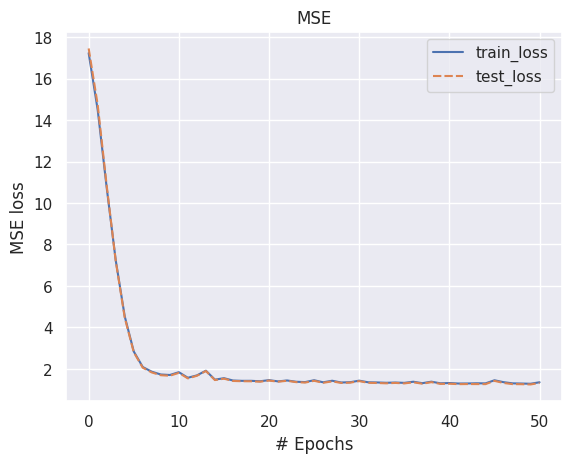

In [692]:
epoch = 50
writer = SummaryWriter()
train_loss, test_loss = [], []

for epoch in range(epoch+1):
    train()
    train_loss.append(test(train_loader))
    test_loss.append(test(test_loader))
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss[-1]:.5f}, Test Loss: {test_loss[-1]:.5f}')
    writer.add_scalar('Loss/train', train_loss[-1], epoch)

writer.flush()
loss_df = pandas.DataFrame({'epochs': range(epoch+1), 'train_loss': train_loss, 'test_loss': test_loss})

seaborn.set_theme()
loss_plot = seaborn.lineplot(loss_df[['train_loss', 'test_loss']])
# loss_plot = seaborn.lineplot(test_loss)
loss_plot.set_title("MSE")
loss_plot.set_xlabel("# Epochs")
loss_plot.set_ylabel("MSE loss")

Text(0.5, 1.0, 'Frequency of loss')

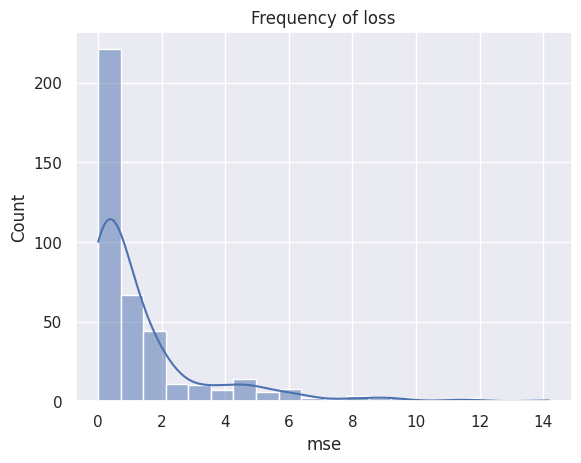

In [693]:
pred_df = pandas.DataFrame(columns=['pred', 'y_true', 'mse'])
model.eval()
for idx, data in enumerate(test_loader):
    out = model(data.x, data.edge_index, data.edge_weight, data.batch)
    for i in range(len(out)):
        prediction = float(out[i][0])
        target = float(data.y[i])
        pred_df.loc[idx] = [prediction, target, float((prediction - target)**2)]

loss_freq_plot = seaborn.histplot(pred_df['mse'], bins=20, kde=True)
loss_freq_plot.set_title("Frequency of loss")

Text(0.5, 1.0, 'mse depending on value of the prediciton')

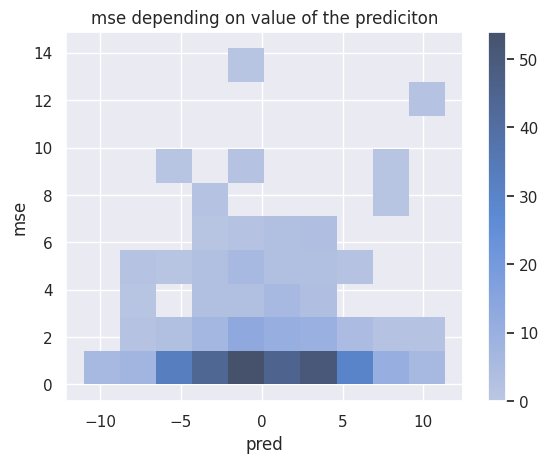

In [694]:
loss_val_plot = seaborn.histplot(data=pred_df['mse'], x=pred_df['pred'], y=pred_df['mse'], bins=10, cbar=True)
loss_val_plot.set_title("mse depending on value of the prediciton")

In [695]:
NUM_POINTS_3D = 10000
RAD = 1.           # vector radius
Theta = numpy.random.uniform(0., numpy.pi, NUM_POINTS_3D)  # random numbers between 0 and pi
Phi = numpy.random.uniform(0., 2.*numpy.pi, NUM_POINTS_3D) # random numbers between 0 and 2*pi

X = RAD*numpy.cos(Phi)*numpy.sin(Theta)
Y = RAD*numpy.sin(Phi)*numpy.sin(Theta)
Z = RAD*numpy.cos(Theta)
spin = numpy.dstack([X, Y, Z], )[0]


In [696]:
0.33007402**2 -0.9428588**2 +  0.04547933**2
-0.86946608**2  + 0.49339037**2 + -0.0243862**2

-0.5131318938122696